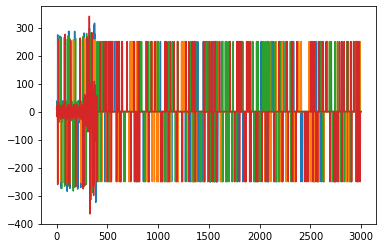

In [71]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

data = pd.read_csv('data/machine_0.csv',index_col=0)

plt.plot(range(len(data)), data)
plt.show()

## Importing Libraries

Importing necessary dependencies to run the jupyter notebook

In [112]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from glob import glob
import pandas as pd
from os import chdir
#from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import KMeans
from scipy import stats

import plotly as px
import plotly.graph_objects as go
import plotly.express as pl
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA 
from scipy import ndimage
from scipy import stats
from sklearn.metrics import mean_squared_error


import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt



import keras
import keras.utils
from pyod.models.auto_encoder import AutoEncoder
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Creating a function to import the data along with preprocessing and noise removal

In [113]:
def importingData(machineNumber):
    machineData = pd.read_csv('data\machine_'+str(machineNumber)+'.csv')
    names = ['dateTime','feature1','feature2','feature3','feature4']
    machineData.columns = names
    machineData['dateTime'] = pd.to_datetime(machineData['dateTime'])
    machineDataF = machineData[['feature1', 'feature2','feature3','feature4']]
    machineDataCleanN =  ndimage.median_filter(np.array(machineDataF),5)
    machineDataClean = pd.DataFrame(machineDataCleanN)
    machineDataClean.columns = ['feature1', 'feature2','feature3','feature4']
    machineDataClean["dateTime"] = machineData["dateTime"]

    return machineDataClean

## Importing the data for all machines

In [114]:
#Loading data of machine x
machine0  = importingData(0)
machine1 = importingData(1)
machine2 = importingData(2)
machine3 = importingData(3)
machine4 = importingData(4)
machine5 = importingData(5)
machine6 = importingData(6)
machine7 = importingData(7)
machine8 = importingData(8)
machine9 = importingData(9)
machine10 = importingData(10)
machine11 = importingData(11)
machine12 = importingData(12)
machine13 = importingData(13)
machine14 = importingData(14)
machine15 = importingData(15)
machine16 = importingData(16)
machine17 = importingData(17)
machine18 = importingData(18)
machine19 = importingData(19)


## Understanding of the data

We can clearly see that the dataset contains a dateTime field providing a stream of data collected every 8 hours in a day and 4 features which correspond to 4 different aspects of a machine that we are unaware of at present. These 4 reading can be of anything ranging from voltage or current readings to temperature, pressure, or RPM of the machine

In [115]:
machine0.head()

,feature1,feature2,feature3,feature4,dateTime
0,8.803120,10.831994,10.083961,8.803120,2019-01-01 00:00:00.000000000
1,8.803120,10.083961,8.803120,-0.672645,2019-01-01 08:00:09.603201067
2,8.803120,10.831994,10.083961,3.691359,2019-01-01 16:00:19.206402134
3,6.525132,10.831994,3.691359,2.816327,2019-01-02 00:00:28.809603201
4,6.525132,6.525132,-0.672645,-3.015832,2019-01-02 08:00:38.412804268


## Creating a function to plot the data 

We create a generic plotting function as we can enter any machine number to get the plot of that particular machine

In [116]:
def plotData(machineData,groups):
    #groups = [1, 2, 3, 4]
    i = 1
    pyplot.figure(figsize=(24,12))
    values = machineData.values
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(machineData.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

## Plot analysis

We take machine 7 as a test subject and analyze the plots of it. We notice that the  features behave consistently for a set amount of time and start behaving differently for a slight time before the sensor fails. Our job now will be to identify the time when this machine starts throwing weird readings and detect the fluctuations

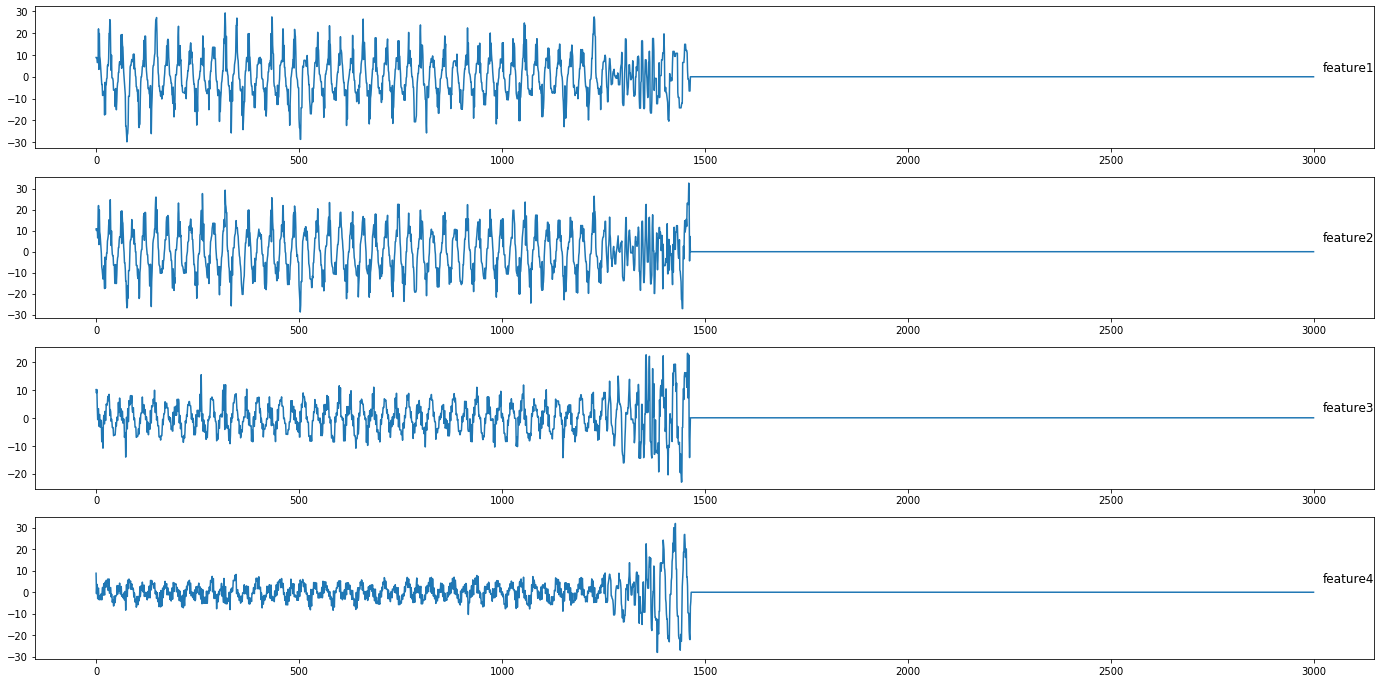

In [117]:
groups = [0, 1, 2, 3]
# plotData(machine0,groups)
# plotData(machine1,groups)
# plotData(machine2,groups)
# plotData(machine3,groups)
# plotData(machine4,groups)
# plotData(machine5,groups)
# plotData(machine6,groups)
plotData(machine7,groups)
# plotData(machine8,groups)
# plotData(machine9,groups)
# plotData(machine10,groups)
# plotData(machine11,groups)
# plotData(machine12,groups)
# plotData(machine13,groups)
# plotData(machine14,groups)
# plotData(machine15,groups)
# plotData(machine16,groups)
# plotData(machine17,groups)
# plotData(machine18,groups)
# plotData(machine19,groups)


In [118]:
machineX = machine7

## Model selection and reasoning

From our analysis above, we notice that we need to find the time when the 4 sensors start behaving differently. This is an anomaly detection problem and we need to try understanding and figuring out the anomalies in the time series. A very good model for time series analysis using deep learning techniques is LSTM as it maintains a memory understanding how the data changes with time and identifies that patters.

<p> Apart from this, we use Autoencoders which is a type of GAN to detect the drop in loss. The encoder and decoder are trained with the part of data that behaves in normal condition and the model is tested on the data that has the information of normal and failed state. When the decoder tries to reconstruct the original sensor data, if the loss is high, it means that the part of reconstruction isn't the normal functioning of the machine and this is an anomaly.</p>

In [119]:
k = machineX[['feature1','feature2','feature3','feature4']]

train_size = int(len(k) * 0.40)
test_size = len(k) - train_size
trainNN, testNN = k.iloc[0:train_size], k.iloc[train_size:len(k)]
scale = MinMaxScaler()

X_trainNN = np.array(trainNN[['feature1','feature2','feature3','feature4']]) 
X_testNN = np.array(testNN[['feature1','feature2','feature3','feature4']])
X_trainNN = stats.zscore(X_trainNN)
X_testNN = stats.zscore(X_testNN)

X_trainNN = X_trainNN.reshape(X_trainNN.shape[0],1,X_trainNN.shape[1])
X_testNN = X_testNN.reshape(X_testNN.shape[0],1,X_testNN.shape[1])

def NN(X):
    inp = Input(shape=(X.shape[1],X.shape[2]))
    LL1 = LSTM(16,activation='relu',return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inp)
    LL2 = LSTM(4,activation='relu',return_sequences=False)(LL1)
    LL3 = RepeatVector(X.shape[1])(LL2)
    LL4 = LSTM(4,activation='relu',return_sequences=True)(LL3)
    LL5 = LSTM(16,activation='relu',return_sequences=True)(LL4)
    out = TimeDistributed(Dense(X.shape[2]))(LL5)
    model = Model(inputs=inp, outputs = out)
    
    return model

model = NN(X_trainNN)
model.compile(optimizer='adam',loss='mae')
model.summary()

n_epoch = 100
batch = 20
hist = model.fit(X_trainNN,X_trainNN,epochs=n_epoch,batch_size=batch,validation_split=0.05).history

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
lstm_22 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_24 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 4)              68  

Epoch 66/100
1140/1140 [==============================] - 0s 252us/step - loss: 0.1228 - val_loss: 0.1282
Epoch 67/100
1140/1140 [==============================] - 0s 241us/step - loss: 0.1215 - val_loss: 0.1293
Epoch 68/100
1140/1140 [==============================] - 0s 273us/step - loss: 0.1210 - val_loss: 0.1268
Epoch 69/100
1140/1140 [==============================] - 0s 238us/step - loss: 0.1206 - val_loss: 0.1281
Epoch 70/100
1140/1140 [==============================] - 0s 234us/step - loss: 0.1204 - val_loss: 0.1274
Epoch 71/100
1140/1140 [==============================] - 0s 248us/step - loss: 0.1202 - val_loss: 0.1268
Epoch 72/100
1140/1140 [==============================] - 0s 253us/step - loss: 0.1197 - val_loss: 0.1252
Epoch 73/100
1140/1140 [==============================] - 0s 245us/step - loss: 0.1196 - val_loss: 0.1273
Epoch 74/100
1140/1140 [==============================] - 0s 244us/step - loss: 0.1199 - val_loss: 0.1263
Epoch 75/100
1140/1140 [======================

## Model analysis

The below plot shows us the trajectory of the model understanding the data with 100 epochs and the loss reducing as the model understands the pattern of the data

(0.0, 0.9)

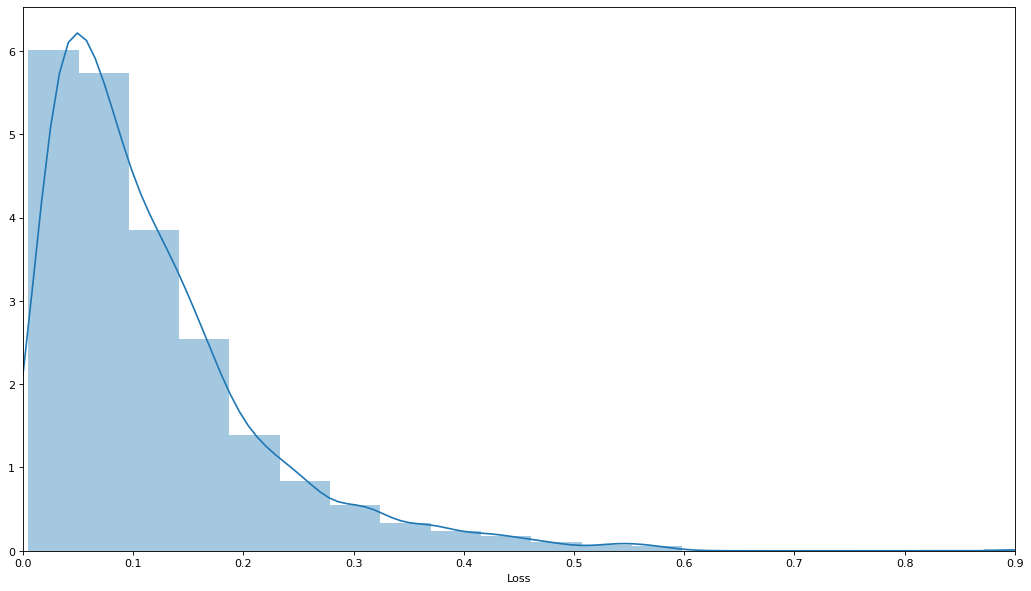

In [120]:
 
x_pred = model.predict(X_trainNN)
x_pred = x_pred.reshape(x_pred.shape[0],x_pred.shape[2])
x_pred = pd.DataFrame(x_pred,columns=['feature1','feature2','feature3','feature4'])
x_pred.index = trainNN.index

score = pd.DataFrame(index=trainNN.index)
XtrainNN = X_trainNN.reshape(X_trainNN.shape[0],X_trainNN.shape[2])
score['Loss'] = np.mean(np.abs(x_pred-XtrainNN),axis=1)
plt.figure(figsize=(16,9),dpi=80)
sns.distplot(score['Loss'],bins=20,kde=True)
plt.xlim([0.00,0.90])

## Setting the limit for anomaly detection

From the plot above, we see that the loss of normal functioning of the machine falls to negligible after 0.6 and we can consider 0.6 to be the loss of normal functioning of the machine. If we have any value greater than 0.6, the model will detect this value as an anomaly.

In [121]:
score['limit'] = 0.6
score['anomaly'] = score['Loss'] > score['limit']
score.head()

,Loss,limit,anomaly
0,0.051120,0.6,False
1,0.406715,0.6,False
2,0.314726,0.6,False
3,0.107734,0.6,False
4,0.031355,0.6,False


## Visualizing the anomalies

The plot below clearly shows the loss values above the boundary condition that clearly indicate the readings at a particular time when different from normal. 

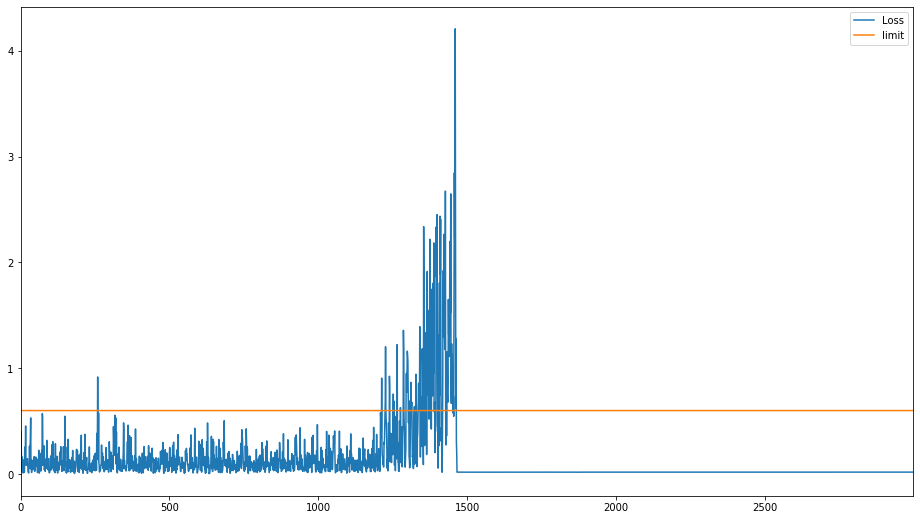

In [122]:
x_pred1 = model.predict(X_testNN)
x_pred1 = x_pred1.reshape(x_pred1.shape[0],x_pred1.shape[2])
x_pred1 = pd.DataFrame(x_pred1,columns=['feature1','feature2','feature3','feature4'])
x_pred1.index = testNN.index

scored_t = pd.DataFrame(index=testNN.index)
XtestNN = X_testNN.reshape(X_testNN.shape[0],X_testNN.shape[2])
scored_t['Loss'] = np.mean(np.abs(x_pred1-XtestNN),axis=1)
scored_t['limit'] = 0.6
scored_t['anomaly'] = scored_t['Loss'] > scored_t['limit']
scoreF = pd.concat([score,scored_t])
scoreF.plot(figsize=(16,9))
machineX['isAnomaly?'] = scoreF['anomaly']

In [123]:
machineX.head()

,feature1,feature2,feature3,feature4,dateTime,isAnomaly?
0,8.828701,10.826737,10.074501,8.828701,2019-01-01 00:00:00.000000000,False
1,8.828701,10.074501,8.828701,-0.665288,2019-01-01 08:00:09.603201067,False
2,8.828701,10.826737,10.074501,3.700640,2019-01-01 16:00:19.206402134,False
3,6.530091,10.826737,3.700640,2.774647,2019-01-02 00:00:28.809603201,False
4,6.530091,6.530091,-0.665288,-3.001026,2019-01-02 08:00:38.412804268,False
